In [1]:
#!pip install efficientnet-pytorch
# !pip install torchsampler

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import os
# from google.colab import drive
import pandas as pd
import numpy as np
import time
from efficientnet_pytorch import EfficientNet
#from torchsampler import ImbalancedDatasetSampler # For balancing dataset

# Check for GPU (else go to settings in Google Colab)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("RUNNING ON ", device) # should be cuda

RUNNING ON  cuda:0


In [2]:
# Model parameters

NUM_EPOCHS= 20
EARLY_STOPPING_LIMIT = 4
NUM_CLASSES = 2     # 2 Neurons at the output layer
BATCHSIZE = 64
LR=5e-5             # Learning rate
LRD_STEP_SIZE = 5   # Period of learning rate decay
LRD_GAMMA = 0.5     # Multiplicative factor of learning rate decay. Default: 0.1
DROPOUT_RATE= 0.4   # probability of an element to be zeroed. Default: 0.5

# *** Paths ***

# ROOT = '/content/drive/'
# MYDRIVE = ROOT + "MyDrive/AffectNet/"
IMAGE_FOLDER = "/data/AffectNet/train_set/images/"
IMAGE_FOLDER_TEST = "/data/AffectNet/val_set/images/"
CSV_PATH = "~/Spielwiese/train_set_annotation_without_lnd.csv"
CSV_PATH_TEST = "~/Spielwiese/val_set_annotation_without_lnd.csv"

# drive.mount(ROOT) # Mount to google drive

Random Train/Val data:


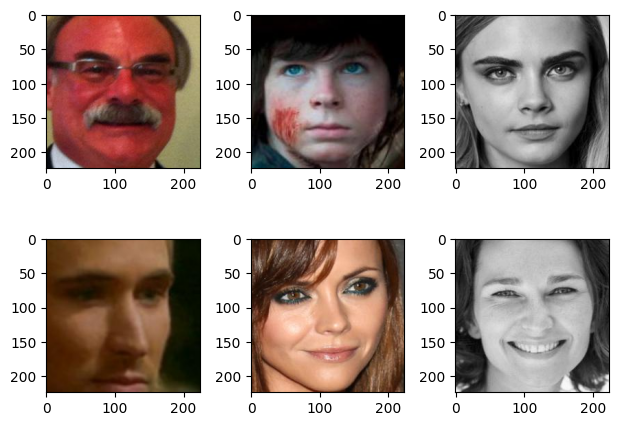

In [3]:
# Inspect random data

print(f"Random Train/Val data:")

fig = plt.figure()
train_val_root = IMAGE_FOLDER
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(Image.open(train_val_root + sorted(os.listdir(train_val_root))[i]))

plt.show()

In [4]:
# Read the csv with the image data

df = pd.read_csv(CSV_PATH)
df_test = pd.read_csv(CSV_PATH_TEST)

df.rename(columns=df.iloc[0])
df_test.rename(columns=df.iloc[0])

# Zähle die Anzahl der Beispiele für jede Klasse in der Spalte 'exp'
print(df['exp'].value_counts())

df['aro'] = df['aro'] * 100
df['val'] = df['val'] * 100
df_test['aro'] = df_test['aro'] * 100
df_test['val'] = df_test['val'] * 100

labels = df[['val', 'aro']].values # define the labels for the model

df.head()

exp
1    134415
0     74874
2     25459
6     24882
3     14090
4      6378
5      3803
7      3750
Name: count, dtype: int64


,number,exp,val,aro
0,0,1,78.57140,-5.555560
1,1,0,-1.72533,0.431332
2,2,0,17.46030,0.793651
3,3,1,15.34010,3.889030
4,5,6,-34.12700,54.761900


In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, balance=True):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.balance = balance

        if self.balance:
            # Balance the dataset by sampling the same number of samples for each class
            self.dataframe = self.balance_dataset()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.dataframe['number'].iloc[idx]}.jpg")

        if os.path.exists(img_name):
            image = Image.open(img_name)
        else:
            # Handle missing image file
            image = Image.new('RGB', (224, 224), color='white')

        labels = torch.tensor(self.dataframe.iloc[idx, 2:4].values, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

    def balance_dataset(self):
        # Group dataframe by the 'exp' column and sample the same number of samples for each class
        balanced_df = self.dataframe.groupby('exp', group_keys=False).apply(lambda x: x.sample(self.dataframe['exp'].value_counts().min()))
        return balanced_df

# Usage
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.CenterCrop(210),
    transforms.RandomGrayscale(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the balanced dataset
custom_dataset_balanced = CustomDataset(dataframe=df, root_dir=IMAGE_FOLDER, transform=transform, balance=True)
custom_test_dataset = CustomDataset(dataframe=df_test, root_dir=IMAGE_FOLDER_TEST, transform=transform, balance=False)


# Reduce dataset
total_size = len(custom_dataset_balanced)
train_size = int(0.5 * total_size)
val_size = int(0 * total_size)
test_size = total_size - train_size - val_size
custom_dataset_balanced, _, _ = random_split(custom_dataset_balanced, [train_size, val_size, test_size])

# Split the dataset into train, validation, and test sets
total_size = len(custom_dataset_balanced)
train_size = int(0.7 * total_size)
val_size = int(0.3 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(custom_dataset_balanced, [train_size, val_size, test_size])

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)
test_loader = DataLoader(custom_test_dataset, batch_size=BATCHSIZE, shuffle=False)

print('Length of train_dataset: ', len(train_dataset), ' ; Length of val_dataset: ', len(val_dataset), ' ; Length of test_dataset: ', len(custom_test_dataset))


Length of train_dataset:  10500  ; Length of val_dataset:  4500  ; Length of test_dataset:  3999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


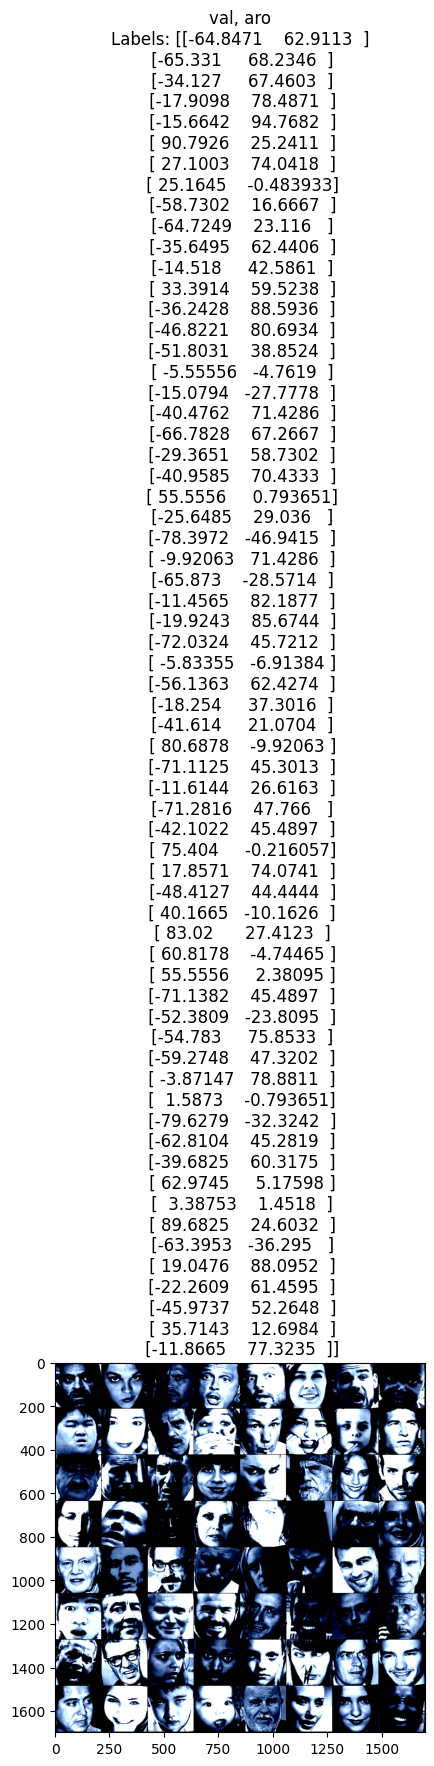

In [8]:
# Test and visualize the train loader

def vis_batch(loader, header=""):
    def show(inp, label):
        fig = plt.gcf()
        plt.imshow(inp.permute(1, 2, 0))
        plt.title(label)
        print(loader)
    for batch_inputs, labels in loader:
        # Move inputs and labels to the device (GPU)
        batch_inputs, labels = batch_inputs.to(device), labels.to(device)

        grid = torchvision.utils.make_grid(batch_inputs.cpu())  # Move to CPU for visualization
        show(grid, label=f'{header}\nLabels: {labels.cpu().numpy()}')
        # plt.show()
        break

vis_batch(train_loader, header="val, aro")

In [ ]:
# SwinT V2: Define the model with dropout and weight decay
class CustomModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CustomModel, self).__init__()
        self.base_model = models.swin_v2_b(weights='DEFAULT')#.to(device)

        # To only train the classifier of the model:
        # for param in self.base_model.parameters():  # We don't want to change the learned ImageNet weights. Disable gradient calculation for CNN
        #    param.requires_grad = False

        n_inputs = self.base_model.head.in_features
        self.base_model.head = nn.Sequential(
            nn.Linear(n_inputs, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

In [6]:
# EfficientNet: Define the model with dropout and weight decay
class CustomModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CustomModel, self).__init__()
        self.base_model = EfficientNet.from_pretrained("efficientnet-b5", advprop=False, num_classes=2, in_channels=3) #  advprop= adversarial training (feindliche Bilder)


        # To only train the classifier of the model:
        # for param in self.base_model.parameters():  # We don't want to change the learned ImageNet weights. Disable gradient calculation for CNN
        #     param.requires_grad = False

        n_inputs = self.base_model._fc.in_features
        self.base_model.head = nn.Sequential(
            nn.Linear(n_inputs, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

In [ ]:
# Define AlexNet model
#class AlexNetRegression(nn.Module):
#    def __init__(self, num_classes=1, dropout_rate=0.5):
#        super(AlexNetRegression, self).__init__()
#
#        self.base_model = models.AlexNet()#.to(device)
#        
#        n_inputs = self.base_model.classifier[6].in_features
#        self.base_model.head = nn.Sequential(
#            nn.Linear(n_inputs, num_classes)
#        )
#
#    def forward(self, x):
#        x = self.base_model(x)
#        return x

In [7]:
model = CustomModel(NUM_CLASSES, DROPOUT_RATE) # Number of output classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Loaded pretrained weights for efficientnet-b7


In [8]:
class CustomLoss(nn.Module):
    def __init__(self, sign_penalty_weight=0.1):
        super(CustomLoss, self).__init__()
        self.sign_penalty_weight = sign_penalty_weight

    def forward(self, predictions, targets):
        # Mean Squared Error (MSE) loss
        mse_loss = nn.functional.mse_loss(predictions, targets)

        # Penalty for wrong sign (excluding zero)
        sign_penalty = torch.mean(torch.relu(-predictions * targets) * torch.sign(targets)) * self.sign_penalty_weight
        
        # Old penalty: 
        # sign_penalty = torch.mean(torch.relu(-predictions * targets)) * self.sign_penalty_weight
        

        # Total loss
        total_loss = mse_loss + sign_penalty

        return total_loss

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LRD_STEP_SIZE, gamma=LRD_GAMMA)
#criterion = nn.MSELoss() 
criterion = CustomLoss(sign_penalty_weight=0.1)

In [9]:
# **** Training ****

model = CustomModel(NUM_CLASSES, DROPOUT_RATE) # Number of output classes
# model = AlexNetRegression(NUM_CLASSES, DROPOUT_RATE)

# Specify the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer with weight decay
class CustomLoss(nn.Module):
    def __init__(self, sign_penalty_weight=0.1):
        super(CustomLoss, self).__init__()
        self.sign_penalty_weight = sign_penalty_weight

    def forward(self, predictions, targets):
        # Mean Squared Error (MSE) loss
        mse_loss = nn.functional.mse_loss(predictions, targets)

        # Penalty for wrong sign (excluding zero)
        sign_penalty = torch.mean(torch.relu(-predictions * targets) * torch.sign(targets)) * self.sign_penalty_weight
        
        # Old penalty: 
        # sign_penalty = torch.mean(torch.relu(-predictions * targets)) * self.sign_penalty_weight
        

        # Total loss
        total_loss = mse_loss + sign_penalty

        return total_loss
    
# optimizer = torch.optim.AdamW(model.base_model.head.parameters(), lr=LR)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LRD_STEP_SIZE, gamma=LRD_GAMMA)
#criterion = nn.MSELoss() 
criterion = CustomLoss(sign_penalty_weight=0.1)

# Assuming you have a DataLoader named 'train_loader'
# Example training loop
print("Start training:")

start = time.time()
early_stopping_counter = 0
previous_val_loss = np.inf
best_val_loss = previous_val_loss

# For plotting
train_loss_history = []
valid_loss_history = []
fig = plt.figure() # For a figur of the training


# model.load_state_dict(torch.load('checkpoint.pt'))   # loading best weights

for epoch in range(NUM_EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    scheduler.step()

    train_loss_history.append(loss.item())

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    average_val_loss = val_loss / len(val_loader)
    valid_loss_history.append(best_val_loss)

    # Early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(),"checkpoint.pt")   # saving best weights so far
    else:
        early_stopping_counter += 1
        if early_stopping_counter == EARLY_STOPPING_LIMIT:
            print("*" * 70)
            model.load_state_dict(torch.load('checkpoint.pt'))      # loading best weights
            print(f"Early-Stopping activated: Using weights from epoch {epoch+1-EARLY_STOPPING_LIMIT}")
            print(f"Result: Validation Loss =  {best_val_loss:.4f}")
            plt.axvline(epoch+1-EARLY_STOPPING_LIMIT, label="Early Stopping", color='r')
            break

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {loss.item()}, Validation Loss: {average_val_loss}, Early Stopping Counter: {early_stopping_counter}, Timestamp: {round(time.time() - start)} seconds')

# Print loss curves
plt.plot(range(1,1+len(train_loss_history)),train_loss_history, label="Training Loss")
if len(train_loss_history) == len(valid_loss_history):
    plt.plot(range(1,1+len(valid_loss_history)),valid_loss_history, label="Validation Loss")
else:
    plt.plot(range(0,len(valid_loss_history)),valid_loss_history, label="Validation Loss")

plt.legend()
plt.show()


print(f"This took {round(time.time() - start)} seconds")

Loaded pretrained weights for efficientnet-b5
Start training:
Epoch 1/20, Training Loss: 2065.2900390625, Validation Loss: 2214.8755948778607, Early Stopping Counter: 0, Timestamp: 104 seconds
Epoch 2/20, Training Loss: 1029.6715087890625, Validation Loss: 1884.3377995020908, Early Stopping Counter: 0, Timestamp: 209 seconds
Epoch 3/20, Training Loss: 1095.19970703125, Validation Loss: 1741.0404413787412, Early Stopping Counter: 0, Timestamp: 308 seconds
Epoch 4/20, Training Loss: 2129.78271484375, Validation Loss: 1591.7467402068662, Early Stopping Counter: 0, Timestamp: 404 seconds
Epoch 5/20, Training Loss: 2073.02978515625, Validation Loss: 1537.6986943634463, Early Stopping Counter: 0, Timestamp: 500 seconds
Epoch 6/20, Training Loss: 2116.729736328125, Validation Loss: 1488.7697203730193, Early Stopping Counter: 0, Timestamp: 595 seconds
Epoch 7/20, Training Loss: 1825.4796142578125, Validation Loss: 1460.226798044124, Early Stopping Counter: 0, Timestamp: 690 seconds
Epoch 8/20,

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

Test Loss: 1423.1410648406497
****************************************
Number of values within the margin of 0.5 for Val and Aro: 6556
Number of values outside the margin of 0.5 for Val and Aro: 1442
Success quote of the prediction: 81.97%
****************************************
Number of values within the margin of 0.25 for Val and Aro: 3921
Number of values outside the margin of 0.25 for Val and Aro: 4077
Success quote of the prediction: 49.02%


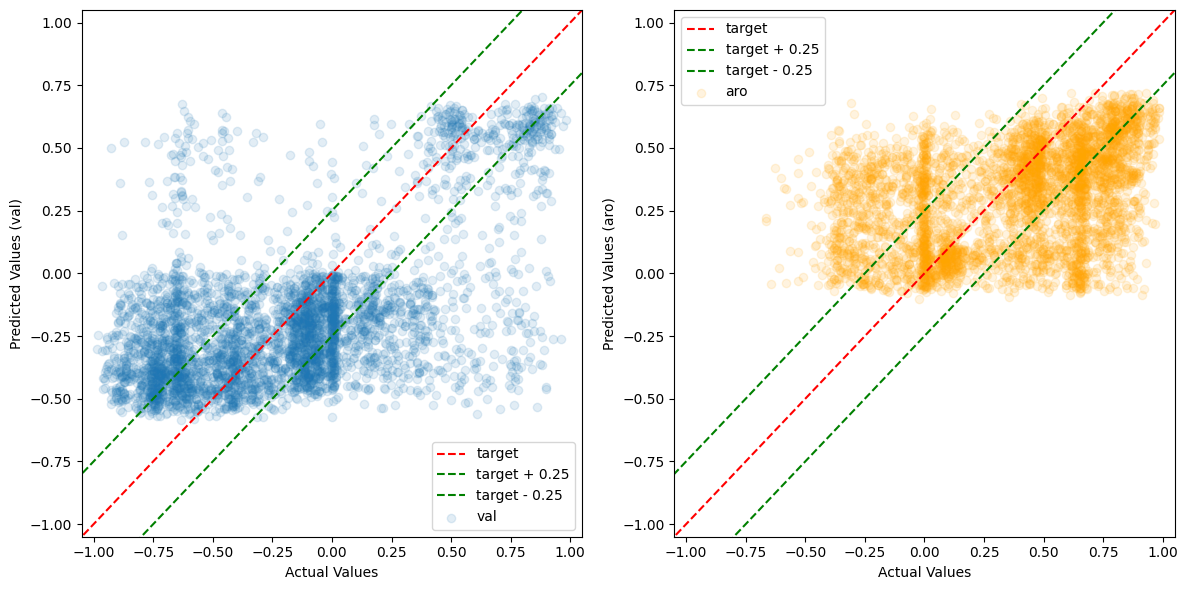

<Figure size 640x480 with 0 Axes>

In [12]:
# Load best weights
model.load_state_dict(torch.load('checkpoint.pt'))

# Test and visualize the performance on the test set
def test_and_visualize(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    predictions = []
    targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            test_loss += criterion(outputs, labels).item()

            predictions.append(outputs.cpu().numpy())
            targets.append(labels.cpu().numpy())

    average_test_loss = test_loss / len(test_loader)

    # Convert lists to numpy arrays
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    # Display performance metrics or visualizations as needed
    print(f'Test Loss: {average_test_loss}')

    return predictions, targets

def count_within_margin(predictions, targets, margin):
    predictions = np.array(predictions)
    targets = np.array(targets)

    # Calculate the absolute difference between predictions and targets
    differences = np.abs(predictions - targets)

    # Count how many values are within the margin
    within_margin = np.sum(differences <= margin)

    # Count how many values are outside the margin
    outside_margin = len(predictions)*2 - within_margin

    print(40*'*')
    print(f"Number of values within the margin of {margin} for Val and Aro: {within_margin}")
    print(f"Number of values outside the margin of {margin} for Val and Aro: {outside_margin}")
    print(f"Success quote of the prediction: {round(within_margin*100/(within_margin+outside_margin),2)}%")

    return within_margin, outside_margin


# Test the model and visualize the performance
predictions, targets = test_and_visualize(model, test_loader, criterion)

predictions = predictions / 100
targets = targets / 100
margin = 0.25

count_within_margin(predictions, targets, 0.5)
count_within_margin(predictions, targets, margin)


# Example: Plotting predicted vs. actual values
x_target= [-1.5, 1.5]
y_target= [-1.5,1.5]
y_target = np.array(y_target)

# Example: Plotting predicted vs. actual values for 'val'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(x_target, y_target, linestyle='--', label='target', color='red')
plt.plot(x_target, y_target + margin, linestyle='--', label='target + '+str(margin), color='green')
plt.plot(x_target, y_target - margin, linestyle='--', label='target - '+str(margin), color='green')

plt.scatter(targets[:, 0], predictions[:, 0], label='val', alpha=0.125)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values (val)')
plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.legend()

# Example: Plotting predicted vs. actual values for 'aro'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(x_target, y_target, linestyle='--', label='target', color='red')
plt.plot(x_target, y_target + margin, linestyle='--', label='target + '+str(margin), color='green')
plt.plot(x_target, y_target - margin, linestyle='--', label='target - '+str(margin), color='green')

plt.scatter(targets[:, 1], predictions[:, 1], label='aro', color='orange', alpha=0.125)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values (aro)')
plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


plt.savefig('./plots/EfficientNet_b5_ReLU_512NN_CustomLoss_BalancedData'+ str(NUM_EPOCHS) +'EPOCHS_'+ str(BATCHSIZE) +'BATCHSIZE_' +str(LR) + 'LR_' + str(LRD_GAMMA) + 'GAMMA_' + str(len(train_dataset)) + 'SIZETRAINDATA_' + '.png')